In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.__version__)
print(torch.version.cuda)

cuda
2.0.1+cu118
11.8


In [2]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [66]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=2):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, num_channels, _, _ = x.size()

        # Global average pooling
        y = self.avg_pool(x).view(batch_size, num_channels)

        # Squeeze
        y = self.fc1(y)
        y = self.relu(y)

        # Excitation
        y = self.fc2(y)
        y = self.sigmoid(y)

        # Reshape and scale
        y = y.view(batch_size, num_channels, 1, 1)
        return x * y

class SpecNetWithSE(nn.Module):
    def __init__(self, in_channels=3):
        super(SpecNetWithSE, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, 
                               kernel_size=3, stride=1, padding=0)
        self.batch1 = nn.BatchNorm2d(8)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        # Add SE block after the first convolutional layer
        self.se_block1 = SEBlock(8)
        
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, 
                               kernel_size=3, stride=1, padding=0)
        self.batch2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # Add SE block after the second convolutional layer
        self.se_block2 = SEBlock(16)
       
        self.fc = nn.Linear(46656, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu1(x)
        
        # Apply SE block after the first convolutional layer
        x = self.se_block1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu2(x)
        
        # Apply SE block after the second convolutional layer
        x = self.se_block2(x)

        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        x = torch.sigmoid(x)
        return x

In [4]:
class SpecNet(nn.Module):
    def __init__(self):
        super(SpecNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, 
                               kernel_size=3, stride=1, padding=0)
        self.batch1 = nn.BatchNorm2d(8)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, 
                               kernel_size=3, stride=1, padding=0)
        self.batch2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
       
        self.fc = nn.Linear(46656, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu2(x)

        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        x = F.softmax(x, dim=1)
        
        return x

In [31]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(in_dim, in_dim)
        self.key = nn.Linear(in_dim, in_dim)
        self.value = nn.Linear(in_dim, in_dim)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        scores = torch.matmul(query, key.transpose(-2, -1)) / (x.size(-1) ** 0.5)
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, value)

        return output

class SpecNetWithAttention(nn.Module):
    def __init__(self):
        super(SpecNetWithAttention, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, 
                               kernel_size=5, stride=1, padding=2)
        self.batch1 = nn.BatchNorm2d(4)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=4)
        
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, 
                               kernel_size=5, stride=1, padding=2)
        self.batch2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=4)
       
        self.attention = SelfAttention(14 * 14 * 16)  # Self-attention layer
        
        self.fc = nn.Linear(14*14*16, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu2(x)

        x = self.pool2(x)

        x = x.view(x.size(0), -1)
        
        # Apply attention
        x = self.attention(x)
        
        # Proceed with the fully connected layer
        x = self.fc(x)

        x = F.softmax(x, dim=1)
        
        return x

In [6]:
class SpectrogramDataset(Dataset):
    def __init__(self, paths_to_spectrograms, transform):
        self.paths_to_spectrograms = paths_to_spectrograms
        self.transform = transform
        self.patient_spectrograms = {}
        self.patient_labels = {}

        for path in paths_to_spectrograms:
            spec_path, label = path.split(' ')
            patient_id = os.path.splitext(os.path.basename(spec_path))[0]
            patient_id = patient_id.split('_')[0]
            
            if patient_id not in self.patient_labels:
                self.patient_labels[patient_id] = int(label)
            
            if patient_id not in self.patient_spectrograms:
                self.patient_spectrograms[patient_id] = []
            self.patient_spectrograms[patient_id].append(spec_path)
    
    def __len__(self):
        return len(self.patient_spectrograms)

    def __getitem__(self, idx):
        patient_id = list(self.patient_spectrograms.keys())[idx]
        spectrogram_paths = self.patient_spectrograms[patient_id]

        # Load and preprocess the spectrograms
        spectrograms = [Image.open(path).convert('L') for path in spectrogram_paths]  # Convert to grayscale

        if self.transform:
            spectrograms = [self.transform(img) for img in spectrograms]

        # Convert to tensors and normalize
        spectrograms = [torch.tensor(np.array(img), dtype=torch.float32) for img in spectrograms]
        spectrograms = [img / 255.0 for img in spectrograms]

        # Stack the spectrograms along a new channel dimension
        combined_spectrogram = torch.stack(spectrograms, dim=0)

        label = self.patient_labels[patient_id]

        return combined_spectrogram, label


In [55]:
file_paths = []
patients_ids = []
file_name = 'dataset_HC_a.txt'

with open(file_name, 'r') as file:
    for line in file:
        file_paths.append(line.strip())

with open(file_name, 'r') as file:
    for line in file:
        spec_path, label = line.split(' ')
        patient_id = os.path.splitext(os.path.basename(spec_path))[0]
        patient_id = patient_id.split('_')[0]
        if patient_id not in patients_ids:
            patients_ids.append(patient_id)

print(file_paths)
print(patients_ids)

['HC_a\\healthy\\10_a_cqt_spectrogram.png 0', 'HC_a\\healthy\\10_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\10_a_spectral_contrast.png 0', 'HC_a\\healthy\\11_a_cqt_spectrogram.png 0', 'HC_a\\healthy\\11_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\11_a_spectral_contrast.png 0', 'HC_a\\healthy\\12_a_cqt_spectrogram.png 0', 'HC_a\\healthy\\12_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\12_a_spectral_contrast.png 0', 'HC_a\\healthy\\130_a_cqt_spectrogram.png 0', 'HC_a\\healthy\\130_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\130_a_spectral_contrast.png 0', 'HC_a\\healthy\\131_a_cqt_spectrogram.png 0', 'HC_a\\healthy\\131_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\131_a_spectral_contrast.png 0', 'HC_a\\healthy\\132_a_cqt_spectrogram.png 0', 'HC_a\\healthy\\132_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\132_a_spectral_contrast.png 0', 'HC_a\\healthy\\133_a_cqt_spectrogram.png 0', 'HC_a\\healthy\\133_a_log_mel_spectrogram.png 0', 'HC_a\\healthy\\133_a_spectral_contrast.png 0', 

Sample 1 - Patient ID: 10 - Label: 0
torch.Size([12, 3, 224, 224]) tensor([1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0])
0


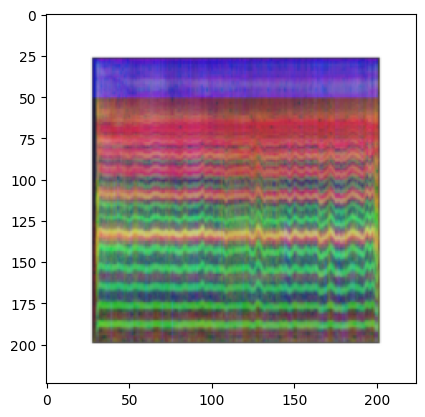

In [56]:
transform = transforms.Compose([
    transforms.Resize((224, 224))
])

dataset = SpectrogramDataset(file_paths, transform)

dataloader = DataLoader(dataset, batch_size=12, shuffle=True)

for i, (data, label) in enumerate(dataloader):
    patient_id = list(dataset.patient_spectrograms.keys())[i]
    patient_label = dataset.patient_labels.get(patient_id, None)
    print(f"Sample {i + 1} - Patient ID: {patient_id} - Label: {patient_label}")
    print(data.shape, label)
    num_spectrograms = data.shape[0]
    print(i)
    img = data[i].numpy()
    img = img.transpose(1, 2, 0)
    plt.imshow(img)
    plt.show()
    if i == 0:
        break


In [67]:
transform = transforms.Compose([
    transforms.Resize((224, 224))
])

acc_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

acc_scores_2 = []
f1_scores_2 = []
precision_scores_2 = []
recall_scores_2 = []


num_epochs = 50
num_splits = 5 
kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)

def get_patient_id(file):
    spec_path, label = file.split(' ')
    patient_id = os.path.splitext(os.path.basename(spec_path))[0]
    patient_id = patient_id.split('_')[0]

    return patient_id

for fold, (train_idx, val_idx) in enumerate(kf.split(patients_ids)):
    print(f"Fold {fold + 1}/{num_splits}")

    train_patients = np.array(patients_ids)[train_idx]
    val_patients = np.array(patients_ids)[val_idx]

    train_files = [file for file in file_paths if get_patient_id(file) in train_patients]
    val_files = [file for file in file_paths if get_patient_id(file) in val_patients]


    train_dataset = SpectrogramDataset(train_files, transform)
    val_dataset = SpectrogramDataset(val_files, transform)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = SpecNetWithSE().to(device)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = to_device(inputs, device), to_device(labels, device)

            optimizer.zero_grad()

            outputs = model(inputs)
            target = labels
            num_classes = 2

            target_one_hot = torch.zeros(target.size(0), num_classes, device=device)
            target_one_hot.scatter_(1, target.unsqueeze(1), 1)

            loss = criterion(outputs, target_one_hot.float())

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {total_loss / len(train_loader)}")

    model.eval()
    correct = 0
    total = 0

    all_labels = []
    all_predicted = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = to_device(inputs, device), to_device(labels, device)
            
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

    f1_2 = f1_score(all_labels, all_predicted)
    precision_2 = precision_score(all_labels, all_predicted)
    recall_2 = recall_score(all_labels, all_predicted)
    accuracy_2 = correct / total

    f1 = f1_score(labels.cpu(), predicted.cpu())
    precision = precision_score(labels.cpu(), predicted.cpu())
    recall = recall_score(labels.cpu(), predicted.cpu())
    accuracy = correct / total
    
    print(f'Fold {fold + 1} Accuracy: {100 * correct / total:.2f}%, F1-score: {f1}, Precision: {precision}, Recall: {recall}')

    acc_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)

    acc_scores_2.append(accuracy_2)
    f1_scores_2.append(f1_2)
    precision_scores_2.append(precision_2)
    recall_scores_2.append(recall_2)

mean_acc = sum(acc_scores) / len(acc_scores)
mean_f1 = sum(f1_scores) / len(f1_scores)
mean_precision = sum(precision_scores) / len(precision_scores)
mean_recall = sum(recall_scores) / len(recall_scores)

std_acc = np.std(mean_acc)
std_f1 = np.std(f1_scores)
std_precision = np.std(precision_scores)
std_recall = np.std(recall_scores)

print(f'Mean Accuracy: {mean_acc:.2f} (±{std_acc:.2f})')
print(f'Mean F1 Score: {mean_f1:.2f} (±{std_f1:.2f})')
print(f'Mean Precision: {mean_precision:.2f} (±{std_precision:.2f})')
print(f'Mean Recall: {mean_recall:.2f} (±{std_recall:.2f})')

mean_acc_2 = sum(acc_scores_2) / len(acc_scores_2)
mean_f1_2 = sum(f1_scores_2) / len(f1_scores_2)
mean_precision_2 = sum(precision_scores_2) / len(precision_scores_2)
mean_recall_2 = sum(recall_scores_2) / len(recall_scores_2)

std_acc_2 = np.std(mean_acc_2)
std_f1_2 = np.std(f1_scores_2)
std_precision_2 = np.std(precision_scores_2)
std_recall_2 = np.std(recall_scores_2)

print(f'Mean Accuracy_2: {mean_acc_2:.2f} (±{std_acc_2:.2f})')
print(f'Mean F1 Score_2: {mean_f1_2:.2f} (±{std_f1_2:.2f})')
print(f'Mean Precision_2: {mean_precision_2:.2f} (±{std_precision_2:.2f})')
print(f'Mean Recall_2: {mean_recall_2:.2f} (±{std_recall_2:.2f})')


Fold 1/5
Epoch [1/50] - Loss: 1.6663530270258586
Epoch [2/50] - Loss: 0.9136795997619629
Epoch [3/50] - Loss: 0.5407655735810598
Epoch [4/50] - Loss: 0.42098872860272724
Epoch [5/50] - Loss: 0.33272143453359604
Epoch [6/50] - Loss: 0.2874779800573985
Epoch [7/50] - Loss: 0.2274094894528389
Epoch [8/50] - Loss: 0.18391877288619676
Epoch [9/50] - Loss: 0.1601201295852661
Epoch [10/50] - Loss: 0.14367859810590744
Epoch [11/50] - Loss: 0.11415250847736995
Epoch [12/50] - Loss: 0.09790829693277676
Epoch [13/50] - Loss: 0.08052310906350613
Epoch [14/50] - Loss: 0.06565575363735358
Epoch [15/50] - Loss: 0.05300465536614259
Epoch [16/50] - Loss: 0.04489837680011988
Epoch [17/50] - Loss: 0.05808389559388161
Epoch [18/50] - Loss: 0.02909414718548457
Epoch [19/50] - Loss: 0.03268719216187795
Epoch [20/50] - Loss: 0.024593282025307417
Epoch [21/50] - Loss: 0.020597724088778097
Epoch [22/50] - Loss: 0.0202814768999815
Epoch [23/50] - Loss: 0.017128706444054842
Epoch [24/50] - Loss: 0.01705136429518

In [68]:
output_file = f'2k3{fold}_e{epoch}_lr001_b{batch_size}_se_{file_name}'

with open(output_file, 'w') as results:
    results.write(f'Mean Accuracy: {mean_acc:.2f} (±{std_acc:.2f}) \n')
    results.write(f'Mean F1 Score: {mean_f1:.2f} (±{std_f1:.2f}) \n')
    results.write(f'Mean Precision: {mean_precision:.2f} (±{std_precision:.2f}) \n')
    results.write(f'Mean Recall: {mean_recall:.2f} (±{std_recall:.2f}) \n')
    results.write(f'Mean Accuracy_2: {mean_acc_2:.2f} (±{std_acc_2:.2f}) \n')
    results.write(f'Mean F1 Score_2: {mean_f1_2:.2f} (±{std_f1_2:.2f}) \n')
    results.write(f'Mean Precision_2: {mean_precision_2:.2f} (±{std_precision_2:.2f}) \n')
    results.write(f'Mean Recall_2: {mean_recall_2:.2f} (±{std_recall_2:.2f}) \n')

In [69]:
torch.save(model.state_dict(), f'1k3{fold}_e{epoch}_lr001_b{batch_size}_se_{file_name}.pt')